In [2117]:
import finance_scrapper as fs
import CAPM_fn as capm
import importlib
importlib.reload(fs)
importlib.reload(capm)

import getFamaFrenchFactors as gff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import datetime as dt
%matplotlib inline

from fredapi import Fred
fred = Fred(api_key='Enter API Key Here') 
# FMP key
key = 'Enter API Key Here' 

import nasdaqdatalink as quandl
Token = "Enter API Key Here"


def reconstruct_BV(ShE, WASHO, ShEpsh_g_3Y):
    try:
        ShEpsh = ShE / WASHO.tail(5).values # ShE limited to 5Y, WASHO is unlimited
        d_ShEpsh = ShEpsh.pct_change() 

        # uses 3Y growth data which is fully available
        constant_G5 = ShEpsh_g_3Y[-1]
        constant_G4 = ShEpsh_g_3Y[-2]
        constant_G3 = ShEpsh_g_3Y[-3]

        # using gt=5, index -1 --> get g2
        X = (1+constant_G4)/(1+constant_G5)
        g2 = X * (1+d_ShEpsh[-1]) - 1

        # using gt=4, index -2 --> g1
        Y = (1+constant_G3)/(1+constant_G4)
        g1 = Y * (1+d_ShEpsh[-2]) - 1

        # deduce g3 using g1 and g2
        g3 = (1+constant_G3)/((1+g1)*(1+g2)) - 1

        # deduce g4 using g2 and g3
        g4 = (1+constant_G4)/((1+g2)*(1+g3)) - 1

        # deduce g5 using g3 and g4
        g5 = (1+constant_G5)/((1+g3)*(1+g4)) - 1

        # build DF for ShEpsh_g_1Y
        ShEpsh_g_1Y = pd.DataFrame(['NaN'] * len(ShEpsh_g_3Y.index[:-5]))
        ShEpsh_g_1Y.index = ShEpsh_g_3Y.index[:-5] #ShEpsh
        ShEpsh_g_1Y = ShEpsh_g_1Y.rename(columns={0:'d_ShEpsh'})

        # Will be added to ShEpsh_g_1Y after ShEpsh_g_1Y is filled
        add_df = pd.DataFrame([g1,g2,g3,g4,g5],index = ShEpsh_g_3Y.index[-5:])
        add_df = add_df.rename(columns={0:'d_ShEpsh'})
        ShEpsh_g_1Y = pd.concat([ShEpsh_g_1Y, add_df], axis=0)

        # to get: ShEpsh_g_1Y index = -6
        # use ShEpsh_g_3Y index -3, -2; ShEpsh_g_1Y index = -3

        for idx in range(len(ShEpsh_g_1Y)-5): # fill from 6th from the last to the first data
            constant_Gt = ShEpsh_g_3Y[-(3+idx)]
            constant_Gt_L1 = ShEpsh_g_3Y[-(4+idx)]
            gt = ShEpsh_g_1Y.iloc[-(3+idx)]

            X = (1+constant_Gt_L1)/(1+constant_Gt)
            gfill = X * (1+gt) - 1

            ShEpsh_g_1Y.iloc[-(idx+6)] = gfill # start from 6th from the last and fill data

        rst_ShEpsh = fs.restoredata(ShEpsh,ShEpsh_g_1Y).rename(columns={'d_ShEpsh': 'ShEpsh'})
    except:
        print('error occurred during Past Book Value of Equity calculation')
    
    try:
        if len(rst_ShEpsh) < len(WASHO):
            rst_start = rst_ShEpsh.index[0]
            # WASHO_ = WASHO.loc[rst_start:]
            WASHO_ = WASHO.iloc[-len(rst_ShEpsh):]
            WASHO_ = fs.equalize_date(WASHO_, rst_ShEpsh['ShEpsh'], 0) # .iloc[1:-1]
            constructed_ShE = rst_ShEpsh['ShEpsh'] * WASHO_ # ShE
        else:
            WASHO_start = WASHO.index[0]
            # rst_ShEpsh_ = rst_ShEpsh.loc[WASHO_start:]
            rst_ShEpsh_ = rst_ShEpsh.iloc[-len(WASHO):]
            rst_ShEpsh_ = fs.equalize_date(rst_ShEpsh, WASHO, 0) # .iloc[1:-1]
            constructed_ShE = rst_ShEpsh_['ShEpsh'] * WASHO # ShE
    except: 
        print('error occurred during Book Value Equity per share calculation')
    
    return constructed_ShE

def get_allROE(BV, NI):
#     BV_start = BV.index[0]
#     NI_ = NI.loc[BV_start:]  
    if len(BV) < len(NI):
        NI_ = NI.iloc[-len(BV):]
        BV = fs.equalize_date(BV, NI_, 0)
    else:
        BV_ = BV.iloc[-len(NI):]
        BV = fs.equalize_date(BV_, NI, 0)
      
    EndE = BV
    AvgE = (BV + BV.shift(1))/2

    roe_endE = NI/EndE
    roe_avgE = NI/AvgE
    
    return roe_endE, roe_avgE

def get_GR(roe_data):
    GR = np.prod(1+roe_data.pct_change()) ** (1/(roe_data.pct_change().count()))
    ROE_gmean = roe_data.copy()

    GR_ser = pd.Series([GR for n in range(len(ROE_gmean))])
    GR_ser.index = ROE_gmean.index
    GR_ser[0] = 1
    
    if pd.isna(ROE_gmean.iloc[0]):
        ROE_gmean.iloc[2:] = ROE_gmean.iloc[1]
        GR_ser = GR_ser.shift(1)
    else:
        ROE_gmean.iloc[1:] = ROE_gmean.iloc[0]
        
    ROE_gmean = ROE_gmean.values * GR_ser.cumprod()
    return ROE_gmean, GR

def S_RIM_ROE_estimates(roe_data):
    # S-RIM estimate using past 5 years ROE data
    S_RIM_ROE_estimates = roe_data.copy()

    # integer weights from the start of data = 1 to end of data = N
    weights = list(range(1,1+roe_data.count()))

    # assign weights to past ROE observations
    # (ROE * range(1,6)).cumsum().values / pd.Series(range(1,6)).cumsum()
    for w in weights:
        x = weights[:w]
        if pd.isna(roe_data.iloc[0]):
            estimates = sum(roe_data[1:w+1] * x)/sum(x)
            S_RIM_ROE_estimates.iloc[w] = estimates
        else:
            estimates = sum(roe_data[0:w] * x)/sum(x)
            # assign 1-period forward S-RIM estimates to t-1 period
            S_RIM_ROE_estimates.iloc[w-1] = estimates
    # Last estimate is the complete S-RIM estimate
    return S_RIM_ROE_estimates # [-1]

# S-RIM ROE_1 estimation
def S_RIM_ROE_Projection(ROE_data, ROE_ttm=None):
    ROE_data = ROE_data.copy()
    
    # Plug in ttm value of ROE if specified
    if ROE_ttm is not None:
        ROE_data.iloc[-1] = ROE_ttm
        
    # Criteria to use S-RIM ROE estimation method:
    # If past ROE has been strictly rising [falling] or geometric return > 1 [GR < 1]: 
    #     Use the last obs data as estimate
    # If past ROE has been neither strictly rising nor falling (or GR = 1):
    #     Use the S-RIM ROE estimation method
    
    # Strictly rising or falling to determine criteria
    if (ROE_data[1:] > ROE_data.shift(1)[1:]).sum() == len(ROE_data[1:]):
        ROE_1 = ROE_data[-1]
        print(f'rising: {ROE_1}')
    elif (ROE_data[1:] < ROE_data.shift(1)[1:]).sum() == len(ROE_data[1:]):
        ROE_1 = ROE_data[-1]
        print(f'falling: {ROE_1}')
    else:
        ROE_1 = S_RIM_ROE_estimates(ROE_data)[-1]
        print(f'sideways: {ROE_1}')
        
    ### OR
    
    # Geometric Return vs 1 to determine criteria
#     ROE_gmean, GR = get_GR(ROE_data)
#     if (GR > 1) or (GR < 1):
#         ROE_1 = ROE_data[-1]
#     else:
#         ROE_1 = S_RIM_ROE_estimates(ROE_data)[-1]

    ROE_data.index = range(1,6)
    ROE_data.loc[6] = ROE_1
    # t=0: now, t+1: estimation period, t-1 ~ t-4: past
    ROE_data.index = ROE_data.index - 5 # now: index_num=5
    
    return ROE_1, ROE_data

def RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w=1):
    RI = B_0 * (ROE_1 - Re)
    V_0 = B_0 + RI * (1/(1+Re-w)) # w/(1+Re-w))
    FV_psh = V_0 / Num_Shares # DWASHO[-1] 
    
    return FV_psh #, RI, B_0, Num_Shares

def input_ratios_sensitivity(B_0, ROE_1, Re, Num_Shares, w, input_name, input_min=0, input_max=1, N=100):
    input_arr = np.linspace(input_min, input_max, N)
    S_RIM_values = []

    if input_name == 'w':
        for x in input_arr:
            w = x
            values = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w)
            S_RIM_values.append(values)

    if input_name == 'ROE':
        for x in input_arr:
            # assumes w=1 constant
            ROE_1 = x
            values = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares, w)
            S_RIM_values.append(values)

    if input_name == 'Re':
        for x in input_arr:
            Re = x
            values = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares, w)
            S_RIM_values.append(values)
            
    inputs_values_variations = pd.DataFrame([input_arr, S_RIM_values]).T.set_axis([f'{input_name}','S-RIM Values'], axis=1)
    inputs_values_variations = inputs_values_variations.set_index(f'{input_name}')

    plt.title(f'{input_name} input variation on S-RIM Values')
    plt.xlabel(f'{input_name}')
    plt.plot(inputs_values_variations)
    plt.grid()
    plt.ylabel('S-RIM Values ($)');
    
def rev_val_derive_Re(V_0, B_0, ROE_1, Num_Shares, w=1, w_0=1):
    Derived_Re = ((V_0 - B_0) - w*(V_0 - B_0) - (B_0 * w_0 * ROE_1)) / (-B_0 * w_0 - (V_0 - B_0))
    return Derived_Re

def rev_val_derive_ROE(V_0, B_0, Re, Num_Shares, w=1, w_0=1):
    Derived_ROE = ((V_0 - B_0) - w*(V_0 - B_0) + Re*(V_0 - B_0) + (B_0 * w_0 * Re)) / (B_0 * w_0)
    return Derived_ROE

In [2508]:
ticker = 'AAPL'
# only limited annual data available, but full annual available for IS and some accounts in BS and CF
# For Free users, these parameters do not matter:
limit = 0
period = ''

### Call FS data
# for FS growth, add parameter growth = True
IS = fs.get_income_statement(ticker, limit, key, period)
BS = fs.get_balance_sheet(ticker, limit, key, period)
# CF = fs.get_cash_flow_statement(ticker, limit, key, period)

fgrowth = fs.get_financial_growth(ticker, limit, key)
ratios = fs.get_financial_ratios(ticker, limit, key,'annual')
ratios_ttm = fs.get_financial_ratios(ticker, limit, key, 'ttm')
# metrics = fs.get_key_metrics(ticker, limit, key, 'annual')
# metrics_ttm = fs.get_key_metrics(ticker, limit, key, 'ttm')

### Clean FS data
IS_df = IS.iloc[8:-2].astype(float).iloc[:, ::-1]
BS_df = BS.iloc[8:-2].astype(float).iloc[:, ::-1]
# CF_df = CF.iloc[8:-2].astype(float).iloc[:, ::-1]

fgrowth_df = fgrowth.iloc[3:].astype(float).iloc[:, ::-1]
ratio_df = ratios.iloc[1:].astype(float).iloc[:, ::-1]
ratio_ttm_df = ratios_ttm.copy()
# metrics_df = metrics.iloc[1:].astype(float).iloc[:, ::-1]
# metrics_ttm_df = metrics_ttm.copy()
quote = fs.get_quote(ticker, key)

ShEpsh_g_10Y = fgrowth_df.loc['tenYShareholdersEquityGrowthPerShare']
ShEpsh_g_5Y = fgrowth_df.loc['fiveYShareholdersEquityGrowthPerShare']
ShEpsh_g_3Y = fgrowth_df.loc['threeYShareholdersEquityGrowthPerShare']

ShE = BS_df.loc['totalStockholdersEquity']
WASHO = IS_df.loc['weightedAverageShsOut']
DWASHO = IS_df.loc['weightedAverageShsOutDil']

NI = IS_df.loc['netIncome']
ROE_ttm = ratio_ttm_df.loc['returnOnEquityTTM'][0]
Num_Shares = quote.loc['sharesOutstanding'][0]

ROE = ratio_df.loc['returnOnEquity']
NPM = ratio_df.loc['netProfitMargin']
ebitM = ratio_df.loc['ebitPerRevenue']
InterestBurden = ratio_df.loc['ebtPerEbit']
TaxBurden = ratio_df.loc['netIncomePerEBT']
ATO = ratio_df.loc['assetTurnover']
FL = ratio_df.loc['companyEquityMultiplier']

In [2439]:
### low risk High quality rates
# Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
AAAFF = fred.get_series('AAAFF')
# ICE BofA US Corporate Index Option-Adjusted Spread = BBB or above
IGspread = fred.get_series('BAMLC0A0CM')

# Investment grade rates 
High_qual_CB_rates = quandl.get("USTREASURY/HQMYC", authtoken=Token)
# ICE BofA BBB US Corporate Index Option-Adjusted Spread
BBBspread = fred.get_series('BAMLC0A4CBBB')
# Moody's Seasoned Baa Corporate Bond Minus Federal Funds Rate = BBB
BAAFF = fred.get_series('BAAFF')

### HY rates
# ICE BofA US High Yield Index Option-Adjusted Spread
HYspread = fred.get_series('BAMLH0A0HYM2')

### Risk-free Treasury rates
# Federal Funds Effective Rate
FFER = fred.get_series('DFF')
ytm_10y = fred.get_series('DGS10')

YC_rates = quandl.get("USTREASURY/YIELD", authtoken=Token)

# RIM Valuation
$V_{0} = B_{0} + \displaystyle\sum_{t=1}^{\infty}\dfrac{B_{t-1}(ROE_{t}-r_{e})}{(1+r_{e})^t}$

constant ROE = 10% means Earnings and Book Value of Equity, Residual Income (RI) grow at 10% speed every year, and g is constant growth rate for RI, which is actually an accelerating factor for earnings growth speed.

With constant ROE, g=0

$B_{1} = B_{0}(1+ROE_{1})$

$B_{2} = B_{1}(1+ROE_{2}) = E_{0}(1+ROE_{1})^2$

With constant ROE, constant g > 0

$B_{1} = B_{0}(1+ROE_{1} * (1+g))$

$B_{2} = B_{1}(1+ROE_{2} * (1+g)) = B_{0}(1+ROE_{1} * (1+g))^2$


With constant ROE, constant g > 0

$RI_{1} = B_{0}(ROE_{1}-r_{e})$

$RI_{2} = B_{1}(ROE_{1}-r_{e}) = B_{0}(1+ROE_{1} * (1+g)) * (ROE_{1}-r_{e})$

$RI_{3} = B_{2}(ROE_{1}-r_{e}) = B_{0}(1+ROE_{1} * (1+g))^2 * (ROE_{1}-r_{e})$

B_1: 152760725000.0
B_2: 168800601125.0
B_1: 152760725000.0
B_2: 168800601125.0
RI_1: -27648999999.999996
RI_2: -30552144999.999996 |RI growth: 10.5% |growth model: 10.5%
RI_3: -33760120224.999996 |RI growth: 10.5% |growth model: 10.5%


' Growth rate g makes BV, ROE, and RI grow at increasing rate which is less realistic in the long term.\n    Thus it make sense of assume g = 0%, because ROE itself is already a growth concept.'

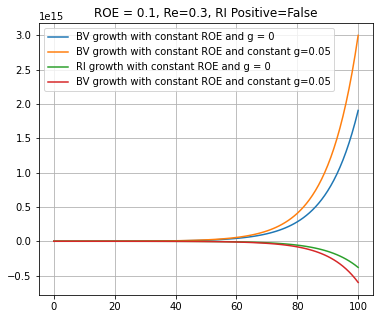

In [2509]:
# ROE_1 = ROE_2 = ROE_3 = ... = constant ROE
ROE_1 = 0.1
Re = 0.3
g = 0.05 # constant growth g

NI_1 = B_0 * ROE_1 * (1+g)
B_1 = B_0 + NI_1
print('B_1:', B_1)

NI_2 = B_1 * ROE_1 * (1+g)
B_2 = B_1 + NI_2
print('B_2:', B_2)

# BV model with constant ROE, Retention rate = 100%, g = 5% (with growth)
B_1 =  B_0 * (1 + ROE_1 * (1+g)) 
print('B_1:', B_1)

B_2 =  B_0 * (1 + ROE_1 * (1+g)) ** 2
print('B_2:', B_2)

RI_1 = B_0 * (ROE_1 - Re)
RI_2 = B_1 * (ROE_1 - Re)
RI_3 = B_2 * (ROE_1 - Re)
print('RI_1:', RI_1)
print('RI_2:', RI_2, 
      '|RI growth:', f'{round(100*(RI_2/RI_1 - 1),5)}%', 
      '|growth model:', f'{100 * round((1 + ROE_1 * (1+g)) - 1,5)}%')
print('RI_3:', RI_3, '|RI growth:', f'{round(100*(RI_3/RI_2 - 1),5)}%', 
      '|growth model:', f'{100 * round((1 + ROE_1 * (1+g))**2 / (1 + ROE_1 * (1+g)) - 1,5)}%')

# Given constant ROE and Re = 0, RI growth = BV growth
# BV is always positive, growing at constant ROE * constant g
# RI is decreasing function of Re, thus may turn negative when ROE < Re
years = 100
BV_constant_ROE = [B_0 * ((1 + ROE_1) ** yr) for yr in range(0,years+1)]
RI_constant_ROE = [B_0 * ((1 + ROE_1) ** yr) * (ROE_1 - Re) for yr in range(0,years+1)]

BV_constant_ROE_and_growth = [B_0 * (1 + ROE_1 * (1+g)) ** yr for yr in range(0,years+1)]
RI_constant_ROE_and_growth = [B_0 * ((1 + ROE_1 * (1+g)) ** yr) * (ROE_1 - Re) for yr in range(0,years+1)]

plt.figure(figsize=(6,5))
plt.plot(BV_constant_ROE, label='BV growth with constant ROE and g = 0')
plt.plot(BV_constant_ROE_and_growth, label=f'BV growth with constant ROE and constant g={g}')

plt.title(f'ROE = {ROE_1}, Re={Re}, RI Positive={ROE_1>Re}')
plt.plot(RI_constant_ROE, label='RI growth with constant ROE and g = 0')
plt.plot(RI_constant_ROE_and_growth, label=f'BV growth with constant ROE and constant g={g}')
plt.grid()
plt.legend();

''' Growth rate g makes BV, ROE, and RI grow at increasing rate which is less realistic in the long term.
    Thus it make sense of assume g = 0%, because ROE itself is already a growth concept.'''

# S-RIM, Perpetual Residual Income (RI) above Cost of Equity (Re)
$RI_{t+1} = B_{t}(ROE_{t+1}-r_{e})$

$RI_{t+1}$ is a assumed as a perpetual Cash Flow (Economic profit) and Present Value of perpetuity = $\dfrac{CF_{t+1}}{r_{e}}$ is a future cash flow premium (in PV) generated from operating assets above a firm's current Book Value of Equity.

Single-stage RIM, same method to calculate Terminal Value of Multiple-stage RIM

$V_{t} = B_{t} + \dfrac{B_{t}(ROE_{t+1}-r_{e})}{r_{e}-g}, g = 0$ due to reason above, to limit from unrealistically increasing

$V_{0} = B_{0} + \dfrac{B_{0}(ROE_{1}-r_{e})}{r_{e}}$

$V_{0} = B_{0} + B_{0}(ROE_{1}-r_{e}) * \dfrac{w}{(1+r_{e}-w)},  w = Persistence Factor, 0<=w<=1$


# RIM, Multiple-stage model

TV with perpetual growth:
$V_{0} = B_{0} + \displaystyle\sum_{t=1}^{T}\dfrac{B_{t-1}(ROE_{t}-r_{e})}{(1+r_{e})^t} + \dfrac{TV_{T}}{(1+r_{e})^T} $

$TV_{T} = \dfrac{B_{T}(ROE_{T+1}-r_{e})}{(r_{e} - g)}$

TV with persistence factor:
$V_{0} = B_{0} + \displaystyle\sum_{t=1}^{T}\dfrac{B_{t-1}(ROE_{t}-r_{e})}{(1+r_{e})^t} + \dfrac{B_{T}(ROE_{T+1}-r_{e})}{(1+r_{e}-w)(1+r_{e})^T}, w = Persistence Factor, 0<=w<=1$

# Preparing Model Input Data

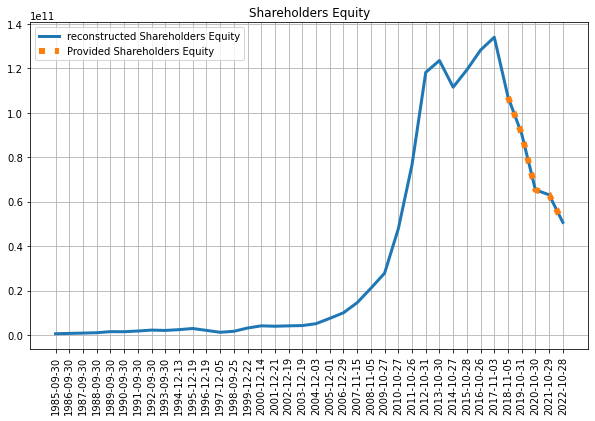

In [2510]:
BV = fs.reconstruct_BV(ShE, WASHO, ShEpsh_g_3Y)
ShE_ = fs.equalize_date(ShE, BV[-5:])

plt.figure(figsize=(10, 6))
plt.plot(BV, label='reconstructed Shareholders Equity', linewidth = 3)
plt.plot(ShE_, label='Provided Shareholders Equity', linewidth = 6, linestyle=':')

plt.grid()
plt.legend()
plt.title('Shareholders Equity')
plt.xticks(rotation=90);

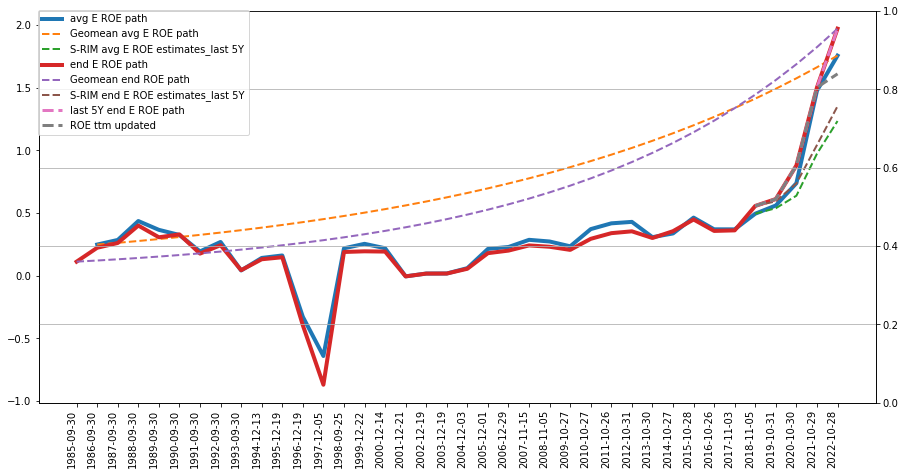

In [2511]:
roe_endE, roe_avgE = fs.get_allROE(BV, NI)

ROE = fs.equalize_date(ROE, NI[-5:], 0)
ROE_ttm_updated = ROE.copy()
ROE_ttm_updated.iloc[-1] = ROE_ttm

ROE_gmean_5Y, GR_5Y = fs.get_GR(ROE)

ROEendE_gmean, GR_endE = fs.get_GR(roe_endE)
ROEavgE_gmean, GR_avgE = fs.get_GR(roe_avgE)

ROEendE_gmean_5Y, GR_endE_5Y = fs.get_GR(roe_endE[-5:])
ROEavgE_gmean_5Y, GR_avgE_5Y = fs.get_GR(roe_avgE[-5:])

S_RIM_ROE_endE = fs.S_RIM_ROE_estimates(roe_endE)
S_RIM_ROE_avgE = fs.S_RIM_ROE_estimates(roe_avgE)

S_RIM_ROE_endE_5Y = fs.S_RIM_ROE_estimates(roe_endE[-5:])
S_RIM_ROE_avgE_5Y = fs.S_RIM_ROE_estimates(roe_avgE[-5:])

roe_avgE_mixedavg = pd.concat([roe_avgE, 
                               ROEavgE_gmean, 
                               ROEavgE_gmean_5Y, 
                               S_RIM_ROE_avgE, 
                               S_RIM_ROE_avgE_5Y], axis = 1).iloc[-5:].mean(axis=1)

roe_endE_mixedavg = pd.concat([roe_endE, 
                               ROEendE_gmean,
                               ROEendE_gmean_5Y,
                               S_RIM_ROE_endE, 
                               S_RIM_ROE_endE_5Y], axis = 1).iloc[-5:].mean(axis=1)

### ROE plots
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

# N = 10
# custom_cycler = (cycler(color = plt.cm.viridis(np.linspace(0,1,N))))
# ax1.set_prop_cycle(custom_cycler)

ax1.plot(roe_avgE, label='avg E ROE path', linewidth=4) # .iloc[-5:]
ax1.plot(ROEavgE_gmean, label='Geomean avg E ROE path', linestyle='--', linewidth=2)
#ax1.plot(S_RIM_ROE_avgE, label='S-RIM avg E ROE estimates_entire data', linestyle='--', linewidth=2)
ax1.plot(S_RIM_ROE_avgE_5Y, label='S-RIM avg E ROE estimates_last 5Y', linestyle='--', linewidth=2)
#ax1.plot(roe_avgE_mixedavg, label='last 5Y mixed avg of avg E ROE', linestyle='--', linewidth=4)

ax1.plot(roe_endE, label='end E ROE path', linewidth=4)
ax1.plot(ROEendE_gmean, label='Geomean end ROE path', linestyle='--', linewidth=2)
#ax1.plot(S_RIM_ROE_endE, label='S-RIM end E ROE estimates_entire data', linestyle='--', linewidth=2)
ax1.plot(S_RIM_ROE_endE_5Y, label='S-RIM end E ROE estimates_last 5Y', linestyle='--', linewidth=2)
#ax1.plot(roe_endE_mixedavg, label='last 5Y mixed avg of end E ROE', linestyle='--', linewidth=4)

ax1.plot(ROE, label='last 5Y end E ROE path', linestyle='--', linewidth=3)
#ax1.plot(ROE_gmean_5Y, label='last 5Y end E ROE Geomean', linestyle='--', linewidth=3)

ax1.plot(ROE_ttm_updated, label='ROE ttm updated', linestyle='--', linewidth=3)

plt.grid()
fig.legend(bbox_to_anchor=(0.12, 0.89), loc="upper left")
fig.autofmt_xdate(rotation=90);

# S-RIM Valuation

In [2512]:
### Cost of Equity Calculation
ytm_10y = fred.get_series('DGS10')
YC_rates = quandl.get("USTREASURY/YIELD", authtoken=Token)
T_yield_10Y = max(ytm_10y[-1], YC_rates['10 YR'][-1])

N = 5
end = dt.datetime.now()
start = end - dt.timedelta(weeks=52*N+2)
interval='1mo'
frequency = {'1d':252, '1wk':52, '1mo': 12}
frequency = frequency[interval]

price_df = capm.get_data_yf([ticker], start, end, interval, OHLC='Adj Close', market=True)
returns_df = capm.simp_ret(price_df)
beta = capm.get_beta_yf(returns_df)
beta = beta[beta['ticker'] == ticker]['Beta'].values[0]

R_mkt = capm.annual_simpret(returns_df['^GSPC'], frequency)
RF = T_yield_10Y/100

# Cost of Equity
COE = RF + beta*(R_mkt - RF)

# Cost of Equity
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename(columns={'date_ff_factors':'Date'}, inplace = True)
ff3_monthly.set_index('Date', inplace = True)

market_premium = ff3_monthly['Mkt-RF'].mean() * 12
Risk_free = ff3_monthly['RF'].mean() * 12
Ke = Risk_free + beta * market_premium
COE, Ke

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(0.06748284832250942, 0.13479897217416392)

rising: 1.6090121317157713


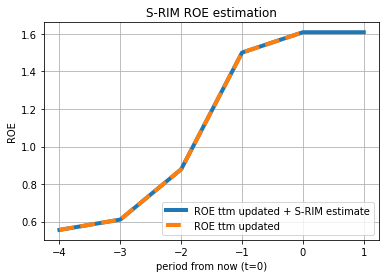

In [2513]:
### S-RIM ROE estimation
ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)

ROE_ttm_updated_ = ROE_ttm_updated.copy()
ROE_ttm_updated_.index = ROE_data.index[:-1]
ROE_ttm_updated_

plt.plot(ROE_data, label='ROE ttm updated + S-RIM estimate', linewidth=4)
plt.plot(ROE_ttm_updated_, label='ROE ttm updated', linewidth=4, linestyle='--')
plt.title('S-RIM ROE estimation')
plt.ylabel('ROE')
plt.grid()
plt.legend()
plt.xlabel('period from now (t=0)');

In [2514]:
### S-RIM Valuation on Entire data
# Single stage S-RIM Valuation Assumes infinite continuation coefficient of residual income above Re, ROE > Re (w=1)

## last BV data
B_0 = BV[-1]

## last + 1 period ROE estimate
# uses S-RIM estimation method based on criteria
ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)

# CAPM estimated Cost of Equity
Re = COE

# Persistence Factor (w)
w = 1

# Outstanding Shares
Num_Shares = DWASHO[-1]


Current_val = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w)

'S-RIM Valuation Output:',Current_val

rising: 1.6090121317157713


('S-RIM Valuation Output:', 74.00464545473237)

# Reversing Valuation Process

In [2515]:
# Current Valuation inputs
B_0 = BV[-1]
ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)
Re = COE
Num_Shares = DWASHO[-1]

# w on denominator
w = 1
# w_0 = persistence factor (w) on numerator 
w_0 = 1

V_0 = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w) * Num_Shares
V_0

rising: 1.6090121317157713


1208186446853.1333

In [2516]:
# Given other inputs hold true, such derived Re is required by investors to reach such valuation/pricing
Derived_Re = rev_val_derive_Re(V_0, B_0, ROE_1, Num_Shares, w=1, w_0=1)
Derived_Re, Re

(0.0674828483225094, 0.06748284832250942)

In [2517]:
# Given other inputs hold true, such derived ROE would be required to reach such valuation/pricing
Derived_ROE = rev_val_derive_ROE(V_0, B_0, Re, Num_Shares, w=1, w_0=1)
Derived_ROE, ROE_1

(1.6090121317157715, 1.6090121317157713)

In [2518]:
# Substituting Current Price as Valuation ouput
V_0 = price.iloc[-1][0] * Num_Shares
Derived_Re = rev_val_derive_Re(V_0, B_0, ROE_1, Num_Shares, w=1, w_0=1)
print(f'Derived Re: {round(Derived_Re*100,2)}%, CAPM Re: {round(Re*100,2)}%')
print(f'Investors require less returns than CAPM: {Derived_Re < Re}')

Derived Re: 6.04%, CAPM Re: 6.75%
Investors require less returns than CAPM: True


In [2519]:
# Substituting Current Price as Valuation ouput
V_0 = price.iloc[-1][0] * Num_Shares
Derived_ROE = rev_val_derive_ROE(V_0, B_0, Re, Num_Shares, w=1, w_0=1)
print(f'Derived ROE: {round(Derived_ROE*100,2)}%, Current ROE: {round(ROE_1*100,2)}%')
print(f'Higher ROE is required to par with valuation given CAPM required returns: {Derived_ROE > ROE_1}')

Derived ROE: 179.77%, Current ROE: 160.9%
Higher ROE is required to par with valuation given CAPM required returns: True


In [2520]:
B_0 = BV[-1]
ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)
Re = COE
Num_Shares = DWASHO[-1]

# w on denominator
w = 1
# w_0 = persistence factor (w) on numerator 
w_0 = 1

### Backtesting Valuation: ROE data vs. ROE estimation
rev_valuation_df = pd.concat([BV, DWASHO, roe_endE], axis=1).set_axis(['BV(t)', 'Num_shares(t)', 'ROE_data(t)'], axis=1)
rev_valuation_df['ROE_estimate(t+1)'] = None
# Valuation Backtest period, or ROE estimation period
valuation_bt_period = 5

dates = pd.DatetimeIndex(rev_valuation_df.index)
end = dt.datetime.now()
start = dates[0]
interval='1mo'
price = capm.get_data_yf([ticker], start, end, interval, OHLC='Adj Close', market=False)

for idx in range(1,len(rev_valuation_df.index)-valuation_bt_period+1):
    sample_roe = rev_valuation_df['ROE_data(t)'][-idx-valuation_bt_period:-idx]
    sample_roe = pd.Series(sample_roe)
    ROE_1, ROE_data = S_RIM_ROE_Projection(sample_roe)
    # t+1 estimates posted for period t's row
    rev_valuation_df['ROE_estimate(t+1)'].iloc[-idx-1] = ROE_1
    
sample_roe = ROE_ttm_updated[-valuation_bt_period:]
sample_roe = pd.Series(sample_roe)
ROE_1, ROE_data = S_RIM_ROE_Projection(sample_roe)
rev_valuation_df['ROE_estimate(t+1)'].iloc[-1] = ROE_1

rev_valuation_df.index = dates
# Used Mean Price instead
price = price.resample('1Y').mean()

if len(rev_valuation_df) < len(price):
    price = price.iloc[-len(rev_valuation_df):]
    price = fs.equalize_date(price, rev_valuation_df,0)
else:
    rev_valuation_df = rev_valuation_df.iloc[-len(price):]
    price = fs.equalize_date(price, rev_valuation_df,0)

rev_valuation_df = pd.concat([price,rev_valuation_df], axis=1).rename(columns={f'{ticker}':'Mkt_Price'})
rev_valuation_df['V_0(Mkt_Price)'] = rev_valuation_df['Mkt_Price'] * rev_valuation_df['Num_shares(t)']

V_0 = rev_valuation_df['V_0(Mkt_Price)']
B_0 = rev_valuation_df['BV(t)']
Re = COE
Num_Shares = rev_valuation_df['Num_shares(t)']
rev_valuation_df['Derived_ROE(t+1)'] = rev_val_derive_ROE(V_0, B_0, Re, Num_Shares, w=1, w_0=1)

V_0 = rev_valuation_df['V_0(Mkt_Price)']
B_0 = rev_valuation_df['BV(t)']
ROE_1 = rev_valuation_df['ROE_estimate(t+1)']
Num_Shares = rev_valuation_df['Num_shares(t)']
rev_valuation_df['Derived_Re(t)'] = rev_val_derive_Re(V_0, B_0, ROE_1, Num_Shares, w=1, w_0=1)

rising: 1.6090121317157713
[*********************100%***********************]  1 of 1 completed
rising: 1.5007132667617693
rising: 0.8786635853012751
sideways: 0.5011707141856506
sideways: 0.4358955273866581
sideways: 0.37191308883268637
sideways: 0.3723863872569141
sideways: 0.37315502554976
sideways: 0.3332750304367852
sideways: 0.314495953531812
sideways: 0.3091975216114161
sideways: 0.2786460450020245
sideways: 0.2437197953104348
sideways: 0.2162089233967291
sideways: 0.20808344105300555
rising: 0.24057252958987055
rising: 0.19921874999999997
rising: 0.17881060809000804
sideways: 0.037564567289965364
sideways: 0.046829144074553325
sideways: 0.0802282661783073
sideways: 0.054668991520562475
sideways: 0.010518312046923018
sideways: -0.10256667915313882
sideways: -0.22063017530800888
sideways: -0.34657829039851684
sideways: -0.045299381717140645
sideways: 0.13599267774201668
sideways: 0.14853776130313492
sideways: 0.17811511580430006
sideways: 0.26057648223994395
sideways: 0.277625411

In [2521]:
RF = YC_rates['10 YR']/100
RF = RF.resample('1M').mean()
price_df = capm.get_data_yf([ticker], start, end, interval, OHLC='Adj Close', market=True)
Beta, Beta_ma = capm.rolling_beta_yf(price_df, ticker, beta_window=12*5, ma_window=6)

# returns_df = capm.simp_ret(price_df)
# R_mkt = capm.annual_simpret(returns_df['^GSPC'], frequency)

if len(RF) < len(Beta):
    Beta = Beta.iloc[-len(RF):]
    RF = fs.equalize_date(RF, Beta,0)
else:
    RF = RF.iloc[-len(Beta):]
    Beta = fs.equalize_date(Beta, RF,0)

CAPM_Re_df = pd.concat([RF,Beta], axis=1).rename(columns={f'{ticker}':'Beta'})

RF = CAPM_Re_df['10 YR']
Beta = CAPM_Re_df['Beta']
CAPM_Re_df['COE'] = RF + Beta*(R_mkt - RF)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


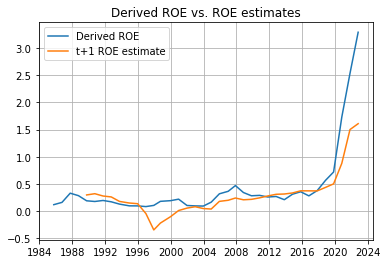

In [2523]:
plt.plot(rev_valuation_df['Derived_ROE(t+1)'], label='Derived ROE')
plt.plot(rev_valuation_df['ROE_estimate(t+1)'], label='t+1 ROE estimate')
plt.grid()
plt.title('Derived ROE vs. ROE estimates')
plt.legend();

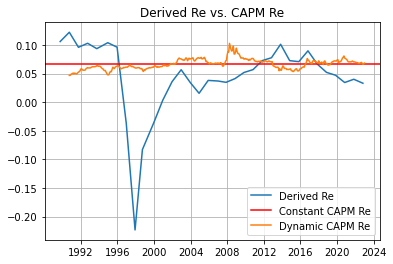

In [2524]:
plt.plot(rev_valuation_df['Derived_Re(t)'], label='Derived Re')
plt.axhline(Re, color='red', label = 'Constant CAPM Re') # constant CAPM Re
plt.plot(CAPM_Re_df['COE'], label = 'Dynamic CAPM Re') # Dynamic CAPM Re using rolling beta, 10Y yields, constant Mkt returns
plt.grid()
plt.title('Derived Re vs. CAPM Re')
plt.legend();

# Valuation Model Input Sensitivity Analysis

rising: 1.6090121317157713


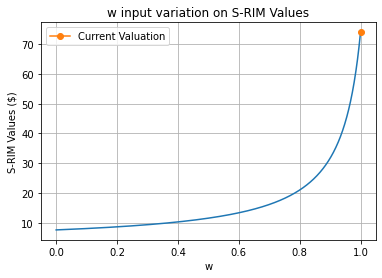

In [2525]:
### Sensitivity analysis with Persistence factor input (w)
# continuation coefficient of Residual Income (RI) above Re
# RI will be reduced by (1-w)% every year until it reaches steady state
# steady state: excess earnings = 0, Earning ROE = Re

# Current Valuation inputs
B_0 = BV[-1]
ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)
Re = COE
Num_Shares = DWASHO[-1]
w = 1

# Input variation
input_name = 'w'
input_min=0 
input_max=1
N = 1000

input_ratios_sensitivity(B_0, ROE_1, Re, Num_Shares, w, input_name, input_min, input_max, N)
plt.plot(w,Current_val, marker='o', label='Current Valuation')
plt.legend();

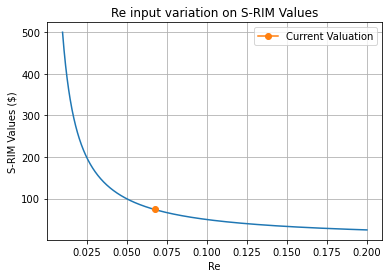

In [2526]:
### Sensitivity analysis with Cost of Equity (w)

# # Current Valuation inputs
# B_0 = BV[-1]
# ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)
# Re = COE
# Num_Shares = DWASHO[-1]
# w = 1

# Input variation
input_name = 'Re'
input_min=0.01
input_max=0.2
N = 1000

input_ratios_sensitivity(B_0, ROE_1, Re, Num_Shares, w, input_name, input_min, input_max, N)
plt.plot(Re,Current_val, marker='o', label='Current Valuation')
plt.legend();

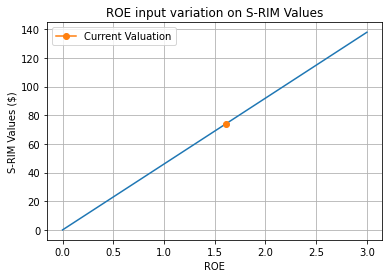

In [2527]:
### Sensitivity analysis with ROE (ROE_1)

# # Current Valuation inputs
# B_0 = BV[-1]
# ROE_1, ROE_data = S_RIM_ROE_Projection(ROE_ttm_updated)
# Re = COE
# Num_Shares = DWASHO[-1]
# w = 1

# Input variation
input_name = 'ROE'
input_min=0
input_max=3
N = 1000

input_ratios_sensitivity(B_0, ROE_1, Re, Num_Shares, w, input_name, input_min, input_max, N)
plt.plot(ROE_1,Current_val, marker='o', label='Current Valuation')
plt.legend();

# Backtesting Valuation Model

In [2528]:
### Backtesting Valuation: ROE data vs. ROE estimation
valuation_df = pd.concat([BV, DWASHO, roe_endE], axis=1).set_axis(['BV(t)', 'Num_shares(t)', 'ROE_data(t)'], axis=1)
valuation_df['ROE_estimate(t+1)'] = None
# Valuation Backtest period, or ROE estimation period
valuation_bt_period = 5

for idx in range(1,len(valuation_df.index)-valuation_bt_period+1):
    sample_roe = valuation_df['ROE_data(t)'][-idx-valuation_bt_period:-idx]
    sample_roe = pd.Series(sample_roe)
    ROE_1, ROE_data = S_RIM_ROE_Projection(sample_roe)
    # t+1 estimates posted for period t's row
    valuation_df['ROE_estimate(t+1)'].iloc[-idx-1] = ROE_1
    
sample_roe = ROE_ttm_updated[-valuation_bt_period:]
sample_roe = pd.Series(sample_roe)
ROE_1, ROE_data = S_RIM_ROE_Projection(sample_roe)
valuation_df['ROE_estimate(t+1)'].iloc[-1] = ROE_1

rising: 1.5007132667617693
rising: 0.8786635853012751
sideways: 0.5011707141856506
sideways: 0.4358955273866581
sideways: 0.37191308883268637
sideways: 0.3723863872569141
sideways: 0.37315502554976
sideways: 0.3332750304367852
sideways: 0.314495953531812
sideways: 0.3091975216114161
sideways: 0.2786460450020245
sideways: 0.2437197953104348
sideways: 0.2162089233967291
sideways: 0.20808344105300555
rising: 0.24057252958987055
rising: 0.19921874999999997
rising: 0.17881060809000804
sideways: 0.037564567289965364
sideways: 0.046829144074553325
sideways: 0.0802282661783073
sideways: 0.054668991520562475
sideways: 0.010518312046923018
sideways: -0.10256667915313882
sideways: -0.22063017530800888
sideways: -0.34657829039851684
sideways: -0.045299381717140645
sideways: 0.13599267774201668
sideways: 0.14853776130313492
sideways: 0.17811511580430006
sideways: 0.26057648223994395
sideways: 0.2776254119288971
sideways: 0.3201501574006281
sideways: 0.2972414196537438
rising: 1.6090121317157713


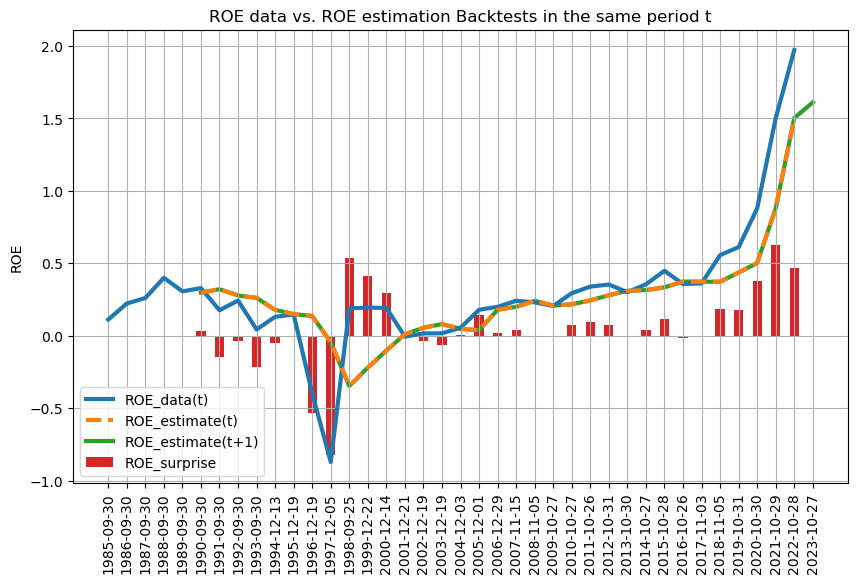

In [2529]:
# shift t+1 estimates to t+1's row and calculate ROE surprises
valuation_df['ROE_surprise(t)'] = valuation_df['ROE_data(t)'] - valuation_df['ROE_estimate(t+1)'].shift(1)

# Visualize ROE data vs. ROE estimation Backtests
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(valuation_df['ROE_data(t)'], label='ROE_data(t)', linewidth=3)
plt.plot(valuation_df['ROE_estimate(t+1)'].shift(1), label='ROE_estimate(t)', linewidth=3, linestyle='--')

plt.bar(valuation_df.index, valuation_df['ROE_surprise(t)'], width=0.5, color='tab:red', label='ROE_surprise')

ROE_estimates = valuation_df['ROE_estimate(t+1)'].copy()
ROE_estimates = ROE_estimates.shift(1)
last_idx = str(pd.DatetimeIndex(ROE_estimates.index)[-1] + dt.timedelta(weeks=52))[:10]
ROE_estimates.loc[last_idx] = valuation_df['ROE_estimate(t+1)'].iloc[-1]
plt.plot(ROE_estimates, label='ROE_estimate(t+1)', linewidth=3, zorder=1)

plt.grid()
plt.legend()
plt.title('ROE data vs. ROE estimation Backtests in the same period t')
plt.ylabel('ROE')
plt.xticks(rotation=90);

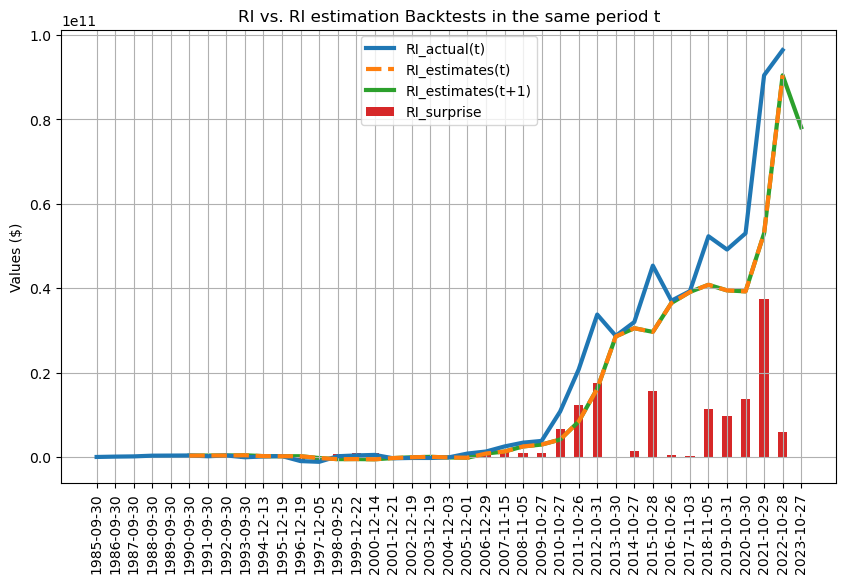

In [2530]:
# Re = COE
# w = 1

# Calculate Residual Income (RI) both actual RI based on actual ROE (t) and expected RI based on ROE esimates (t+1)
# expected RI based on ROE esimates (t+1) is what actually determines the actual valuation output
# assume constant Re and w=1
valuation_df['RI_actual(t)'] = valuation_df['BV(t)'] * (valuation_df['ROE_data(t)'] - Re)
valuation_df['RI_estimates(t+1)'] = valuation_df['BV(t)'] * (valuation_df['ROE_estimate(t+1)'] - Re)
valuation_df['RI_surprise(t)'] = valuation_df['RI_actual(t)'] - valuation_df['RI_estimates(t+1)'].shift(1)

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(valuation_df['RI_actual(t)'], label='RI_actual(t)', linewidth=3)
plt.plot(valuation_df['RI_estimates(t+1)'].shift(1), label='RI_estimates(t)', linewidth=3, linestyle='--')


RI_estimates = valuation_df['RI_estimates(t+1)'].copy()
RI_estimates = RI_estimates.shift(1)
last_idx = str(pd.DatetimeIndex(RI_estimates.index)[-1] + dt.timedelta(weeks=52))[:10]
RI_estimates.loc[last_idx] = valuation_df['RI_estimates(t+1)'].iloc[-1]
plt.plot(RI_estimates, label='RI_estimates(t+1)', linewidth=3, zorder=1)


plt.bar(valuation_df.index, valuation_df['RI_surprise(t)'], width=0.5, color='tab:red', label='RI_surprise')

plt.grid()
plt.legend()
plt.title('RI vs. RI estimation Backtests in the same period t')
plt.ylabel('Values ($)')
plt.xticks(rotation=90);

[*********************100%***********************]  1 of 1 completed


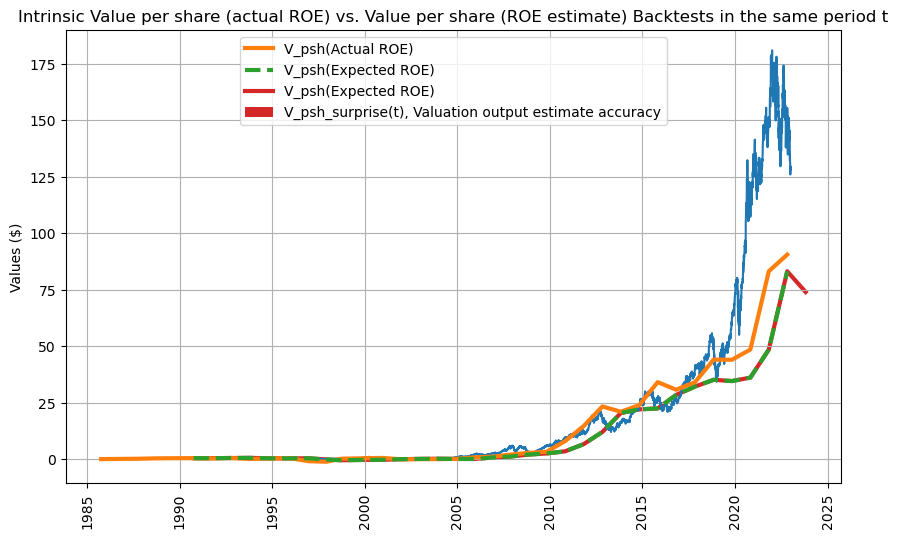

In [2531]:
# Re = COE
# w = 1

valuation_df['V_0(Expected ROE)'] = valuation_df['BV(t)'] + valuation_df['RI_estimates(t+1)'] * (w/(1+Re-w))
valuation_df['V_0(Actual ROE)'] = valuation_df['BV(t)'] + valuation_df['RI_actual(t)'] * (w/(1+Re-w))

valuation_df['V_psh(Expected ROE)'] = valuation_df['V_0(Expected ROE)'] / valuation_df['Num_shares(t)']
valuation_df['V_psh(Actual ROE)'] = valuation_df['V_0(Actual ROE)'] / valuation_df['Num_shares(t)']

# Measure of Valuation Accuracy from ROE estimation
valuation_df['V_psh_surprise(t)'] = valuation_df['V_psh(Actual ROE)'] - valuation_df['V_psh(Expected ROE)'].shift(1)

# Get historical stock prices
dates = pd.DatetimeIndex(valuation_df.index)
end = dt.datetime.now()
start = dates[0]
interval='1d'
price = capm.get_data_yf([ticker], start, end, interval, OHLC='Adj Close', market=False)


### Visualize Valuation outputs
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(price)

# Convert valuation_df index into dt object
valuation_df.index = dates

plt.plot(valuation_df['V_psh(Actual ROE)'], label='V_psh(Actual ROE)', linewidth=3)
plt.plot(valuation_df['V_psh(Expected ROE)'].shift(1), label='V_psh(Expected ROE)', linewidth=3, linestyle='--')
plt.bar(valuation_df.index, valuation_df['V_psh_surprise(t)'], width=0.5, color='tab:red', label='V_psh_surprise(t), Valuation output estimate accuracy')


Val_estimates = valuation_df['V_psh(Expected ROE)'].copy()
Val_estimates = Val_estimates.shift(1)
last_idx = str(pd.DatetimeIndex(Val_estimates.index)[-1] + dt.timedelta(weeks=52))[:10]
Val_estimates.loc[last_idx] = valuation_df['V_psh(Expected ROE)'].iloc[-1]
plt.plot(Val_estimates, label='V_psh(Expected ROE)', linewidth=3, zorder=1)

plt.grid()
plt.legend()
plt.title('Intrinsic Value per share (actual ROE) vs. Value per share (ROE estimate) Backtests in the same period t')
plt.ylabel('Values ($)')
plt.xticks(rotation=90);

In [2532]:
Current_val

74.00464545473237

In [2533]:
valuation_df['V_psh(Expected ROE)'][-1]

74.00464545473237

# DuPont Decomposition of ROE

In [2551]:
ratio_df.iloc[:,-1].loc[['returnOnEquity',
                         'netProfitMargin',
                         'ebitPerRevenue',
                         'ebtPerEbit',
                         'netIncomePerEBT',
                         'assetTurnover',
                         'companyEquityMultiplier']]

returnOnEquity             1.969589
netProfitMargin            0.253096
ebitPerRevenue             0.302887
ebtPerEbit                 0.997204
netIncomePerEBT            0.837955
assetTurnover              1.117852
companyEquityMultiplier    6.961537
Name: 2022-09-24, dtype: float64

In [2552]:
ratio_ttm_df.iloc[:,-1].loc[['returnOnEquityTTM',
                         'netProfitMarginTTM',
                         'ebitPerRevenueTTM',
                         'ebtPerEbitTTM',
                         'netIncomePerEBTTTM',
                         'assetTurnoverTTM',
                         'companyEquityMultiplierTTM']]

returnOnEquityTTM             1.609012
netProfitMarginTTM            0.253096
ebitPerRevenueTTM             0.302887
ebtPerEbitTTM                 0.997204
netIncomePerEBTTTM            0.837955
assetTurnoverTTM              1.117852
companyEquityMultiplierTTM    6.961537
Name: AAPL TTM Ratios, dtype: float64

In [2557]:
def get_ratios_and_ttm(ratio_name, ratio_df, ratio_ttm_df):
    ratio = ratio_df.loc[ratio_name].copy()
    ratio.iloc[-1] = ratio_ttm_df.loc[ratio_name+'TTM'][0]
    return ratio

# ROE = get_ratios_and_ttm('returnOnEquity', ratio_df, ratio_ttm_df)
# NPM = get_ratios_and_ttm('netProfitMargin', ratio_df, ratio_ttm_df)
# ebitM = get_ratios_and_ttm('ebitPerRevenue', ratio_df, ratio_ttm_df)
# InterestBurden = get_ratios_and_ttm('ebtPerEbit', ratio_df, ratio_ttm_df)
# TaxBurden = get_ratios_and_ttm('netIncomePerEBT', ratio_df, ratio_ttm_df)
# ATO = get_ratios_and_ttm('assetTurnover', ratio_df, ratio_ttm_df)
# FL = get_ratios_and_ttm('companyEquityMultiplier', ratio_df, ratio_ttm_df)

ROE = ratio_df.loc['returnOnEquity']
NPM = ratio_df.loc['netProfitMargin']
ebitM = ratio_df.loc['ebitPerRevenue']
InterestBurden = ratio_df.loc['ebtPerEbit']
TaxBurden = ratio_df.loc['netIncomePerEBT']
ATO = ratio_df.loc['assetTurnover']
FL = ratio_df.loc['companyEquityMultiplier']

In [2558]:
# Checking for DuPont ROE Compositions calculation
n_accuracy = 12
ROE.round(n_accuracy) == (NPM * ATO * FL).round(n_accuracy), \
ROE.round(n_accuracy) == (ebitM * InterestBurden * TaxBurden * ATO * FL).round(n_accuracy)

(date
 2018-09-29    True
 2019-09-28    True
 2020-09-26    True
 2021-09-25    True
 2022-09-24    True
 dtype: bool,
 date
 2018-09-29    True
 2019-09-28    True
 2020-09-26    True
 2021-09-25    True
 2022-09-24    True
 dtype: bool)

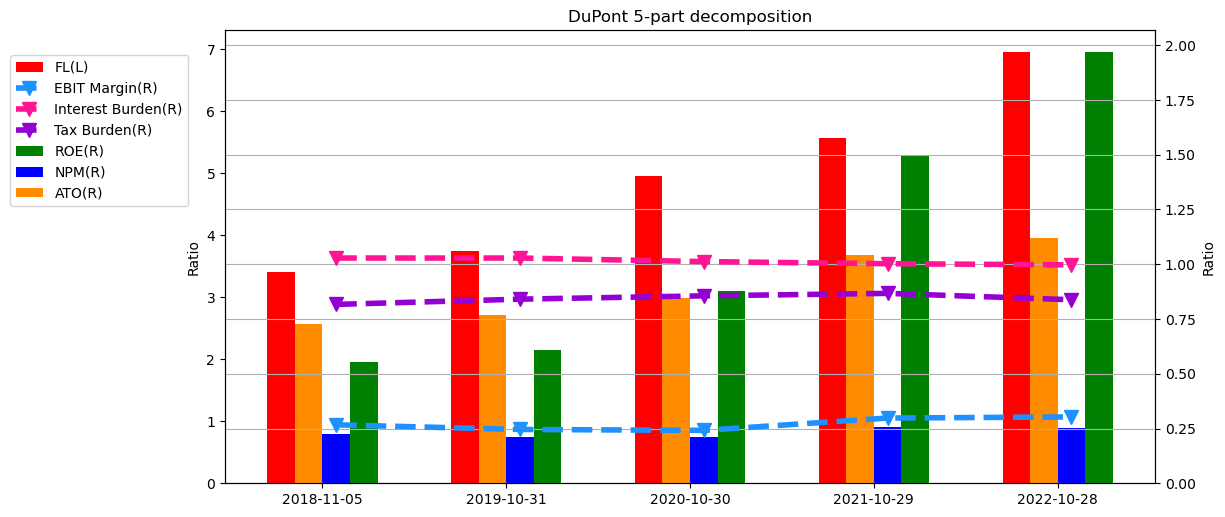

In [2538]:
# DuPont 5-part decomposition
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=100)
ax2 = ax1.twinx()

w = 0.15
n = len(ROE)
x = np.arange(n)
# (w*(1-n)/2) + 1*w
ax2.bar((x+3*w/2), ROE, width=w, label='ROE(R)', color='g')
ax2.bar((x+1*w/2), NPM, width=w, label='NPM(R)', color='b')
ax2.bar((x-1*w/2), ATO, width=w, label='ATO(R)', color='darkorange')
ax1.bar((x-3*w/2), FL,width=w, label='FL(L)', color='r')

ax2.plot((x+1*w/2), ebitM, label='EBIT Margin(R)', color='dodgerblue', linewidth=4, marker='v', markersize = 10, linestyle='--')
ax2.plot((x+1*w/2), InterestBurden, label='Interest Burden(R)', color='deeppink', linewidth=4, marker='v', markersize = 10, linestyle='--')
ax2.plot((x+1*w/2), TaxBurden, label='Tax Burden(R)', color='darkviolet', linewidth=4,marker='v', markersize = 10, linestyle='--')

plt.xticks(x, ROE.index)

plt.title('DuPont 5-part decomposition')
ax1.set_ylabel('Ratio')
ax2.set_ylabel('Ratio')
# ax2.set_zorder(2)
# ax1.set_zorder(1)

ax2.grid()
fig.legend(bbox_to_anchor=(-0.06, 0.85), loc="upper left");

In [2539]:
ROE = get_ratios_and_ttm('returnOnEquity', ratio_df, ratio_ttm_df)

estimate_NPM, estimate_data_NPM = S_RIM_ROE_Projection(NPM)
estimate_ebitM, estimate_data_ebitM = S_RIM_ROE_Projection(ebitM)
estimate_InterestBurden, estimate_data_InterestBurden = S_RIM_ROE_Projection(InterestBurden)
estimate_TaxBurden, estimate_data_TaxBurden = S_RIM_ROE_Projection(TaxBurden)
estimate_ATO, estimate_data_ATO = S_RIM_ROE_Projection(ATO)
estimate_FL, estimate_data_FL = S_RIM_ROE_Projection(FL)

# ROE estimates
estimate_ROE, estimate_data_ROE = S_RIM_ROE_Projection(ROE)
ROE_3 = estimate_NPM * estimate_ATO * estimate_FL
ROE_5 = estimate_ebitM * estimate_InterestBurden * estimate_TaxBurden * estimate_ATO * estimate_FL

sideways: 0.2384710679130323
sideways: 0.2792354907650539
falling: 0.997203546639651
sideways: 0.8481695331284971
rising: 1.1178523337727317
rising: 6.961536943479634
rising: 1.6090121317157713


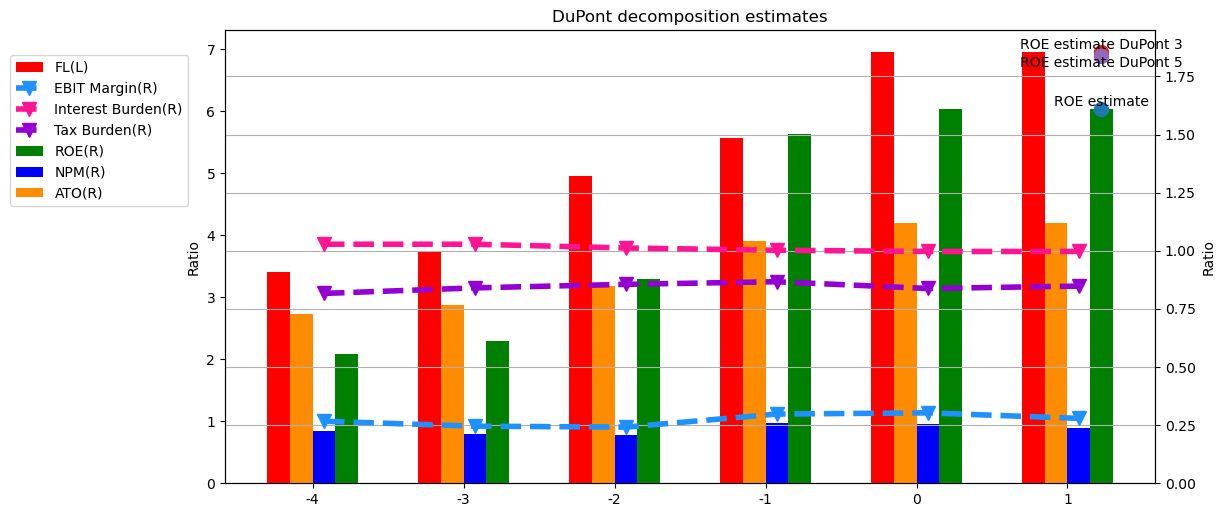

In [2540]:
# DuPont 5-part decomposition ### ESTIMATES ###
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=100)
ax2 = ax1.twinx()

w = 0.15
n = len(estimate_data_ROE)
x = np.arange(n)
# (w*(1-n)/2) + 1*w
ax2.bar((x+3*w/2), estimate_data_ROE, width=w, label='ROE(R)', color='g')
ax2.bar((x+1*w/2), estimate_data_NPM, width=w, label='NPM(R)', color='b')
ax2.bar((x-1*w/2), estimate_data_ATO, width=w, label='ATO(R)', color='darkorange')
ax1.bar((x-3*w/2), estimate_data_FL,width=w, label='FL(L)', color='r')

ax2.plot((x+1*w/2), estimate_data_ebitM, label='EBIT Margin(R)', color='dodgerblue', linewidth=4, marker='v', markersize = 10, linestyle='--')
ax2.plot((x+1*w/2), estimate_data_InterestBurden, label='Interest Burden(R)', color='deeppink', linewidth=4, marker='v', markersize = 10, linestyle='--')
ax2.plot((x+1*w/2), estimate_data_TaxBurden, label='Tax Burden(R)', color='darkviolet', linewidth=4,marker='v', markersize = 10, linestyle='--')

ax2.plot(5.225,estimate_ROE ,marker='o', markersize=10, color='tab:blue')
ax2.text(5.225,estimate_ROE ,s='ROE estimate', verticalalignment = 'bottom', horizontalalignment ='center')

ax2.plot(5.225,ROE_3 ,marker='o', markersize=10, color='tab:red')
ax2.text(5.225,ROE_3 ,s='ROE estimate DuPont 3', verticalalignment = 'bottom', horizontalalignment ='center')

ax2.plot(5.225,ROE_5 ,marker='o', markersize=10, color='tab:purple')
ax2.text(5.225,ROE_5 ,s='ROE estimate DuPont 5', verticalalignment = 'top', horizontalalignment ='center')

plt.xticks(x, estimate_data_ROE.index)

plt.title('DuPont decomposition estimates')
ax1.set_ylabel('Ratio')
ax2.set_ylabel('Ratio')
# ax2.set_zorder(2)
# ax1.set_zorder(1)

ax2.grid()
fig.legend(bbox_to_anchor=(-0.06, 0.85), loc="upper left");

In [2541]:
### DuPont 3-parts ROE estimation
B_0 = BV[-1]
# DuPont ROE estimation
ROE_1 = ROE_3
Re = COE
w = 1
Num_Shares = DWASHO[-1]

Current_val = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w)
Current_val

85.35420670212638

In [2542]:
### DuPont 5-parts ROE estimation
B_0 = BV[-1]
# DuPont ROE estimation
ROE_1 = ROE_5
Re = COE
w = 1
Num_Shares = DWASHO[-1]

Current_val = RIM_valuation_single_stage(B_0, ROE_1, Re, Num_Shares,  w)
Current_val

84.53300985239923